# Project

## Introduction to the Project
The S&P 500 (Standard & Poor's 500) is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as one of the best representations of the U.S. stock market and economy. Over the long term, the S&P 500 has shown consistent growth, making it a key focus for long-term investors. However, it can also experience significant volatility in the short term.

In this project, we will make our first attempt to build a momentum-based strategy to trade the S&P 500 index. At the end of the project, you will have built a program that you can later expand and customise to suit your needs. We will use the python packages numpy, scipy and sqlite3, among others, in this project.

Tips: Review the code snippets that we went through during the course. Reorganize them and you are half-way done! Try experimenting with different configurations of the confidence interval, the lookback window and the forecast horizon. Be brave and experiment with different ways of deciding the position size. You may be surprised by your talent!

Re-organize your code from the exercises into a Python program that 
1. read prices from a database
2. calibrate a GBM model on each day when new prices are received.
3. forecast the price in e.g. 10 days and
   1. calculate the confidence interval of the forecast
   2. calculate the expected shortfall from the price forecast
4. code your trading signals using the price forecast and the expected shortfall.
5. store your postions into the *positions* table after each trade.
6. produce a 1-year backtest record from 2020-06-01 to 2021-05-31.


In [6]:
import csv
# import sqlite3
# from contextlib import closing
from datetime import datetime

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# conn = sqlite3.connect("SP500.db")
# cs = conn.cursor()
import pandas as pd
import yfinance as yf


# dependent functions
from GBM import GBM
# download and save 'adj close' prices for S&P500
sp500 = yf.download('^GSPC', start='2010-01-01', end='2024-12-31',auto_adjust=False)
stockprice = sp500[('Adj Close', '^GSPC')].to_frame(name = 'price')

[*********************100%***********************]  1 of 1 completed


## 1. Collect all the code related to the GBM model into a class

#### Forcast Stock prices using GBM:

Assume the stock price follows a Geometric Brownian Motion (GBM), defined by the stochastic differential equation:
$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$
The solution for future stock prices can be expressed as:
\begin{split}
    S_t &= S_0 exp[(\mu-\frac{\sigma^2}{2})t+\sigma W_t] \\
E[S_t]  &= E[S_0 exp[(\mu-\frac{\sigma^2}{2})t+\sigma W_t]] \\
        &= S_0 exp[(\mu-\frac{\sigma^2}{2})t] E[exp[\sigma W_t]] \\
        &= S_0 exp[(\mu-\frac{\sigma^2}{2})t] E[exp[\sigma \sqrt{t}Z]] \\
        &= S_0 exp[(\mu-\frac{\sigma^2}{2})t] exp[\sigma^2 t/2] \\
        &= S_0 exp[\mu t] \\
\end{split}
We can calcualte confidence interval from the log-normal distribution of the stock price:
$$ln\frac{S_t}{S_0} = ln S_t - ln S_0 \sim N [(\mu-\frac{\sigma^2}{2})t, \sigma^2 t] $$


#### Simulate Trajectories of GBM
In the SDE that defines GBM, the brownian motion $W_t$ is simply accumulated from each time step $\Delta t$


In [2]:
# test the model
from GBM import GBM
# Calibrate the model using first year of data
oldprice = stockprice.loc['2010-01-01':'2010-12-31']['price']
model = GBM()
model.calibrate(oldprice, 1/252)
print(f"mu: {model.mu}, sigma: {model.sigma}")

# Forecast the next year
latest = float(oldprice[-1])
T = 1
confidence = 0.90
N = 252
Dt = 1/N
expect = []
lower = []
upper = []
for i in range(1, N+1):
    forecast = model.forecast(latest, Dt*i, confidence)
    expect.append(forecast['expected'])
    lower.append(forecast['interval'][0])
    upper.append(forecast['interval'][1])
print(f"Expected price: {expect[-1]}")
print(f"Confidence interval: [{lower[-1]}, {upper[-1]}]")

# Simulate 5 trajectories
N = 252
K = 5
Dt = 1/N
S0 = latest
trajectories = model.simulate(N, K, Dt, S0)

mu: 0.11103684942230187, sigma: 0.17537915576560098
Expected price: 1405.3323317549732
Confidence interval: [1037.0932471193692, 1846.640285551923]


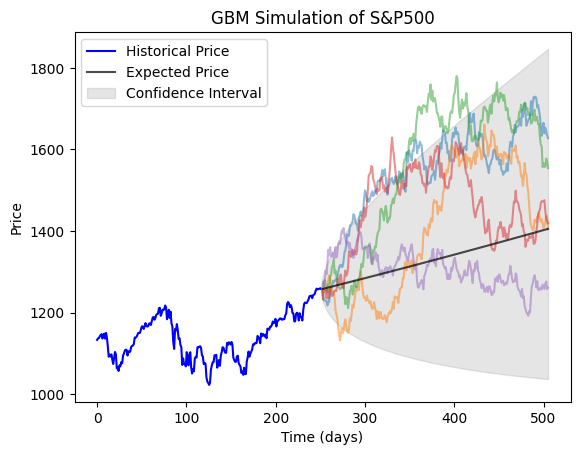

In [3]:
plt.plot(np.linspace(0,N,N), oldprice.to_list(), color='blue', label='Historical Price')
plt.plot(np.linspace(N, N+N+1,N+1), trajectories, alpha=0.5)

plt.plot(np.linspace(N+1, N+N+1,N), expect, color='black', alpha=0.7, label='Expected Price')
plt.fill_between(np.linspace(N, N+N+1,N), lower, upper, color='gray', alpha=0.2, label='Confidence Interval')

plt.title('GBM Simulation of S&P500')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

Most of the trajectories of the stocks show strong growth but with periods of time when the price goes down sharply and might cause a few rounds of panic selling. The random fluctuations are all captured by the volatility parameter $\sigma$.

## 2. Write a function that prepares the database for trading, 
i.e.
   1. load the historical prices into the *prices* table
   2. create the *positions* table
   3. initialize the *positions* table with the your initial cash reserve. The initial *time_of_trade* can be any date before the earliest possible trading date.

    Call this function *prepare*.

In [2]:
def prepare():
    # TODO: Your code goes here
    positions = pd.DataFrame([{
        'time_of_trade' : pd.to_datetime('2000-01-01'),
        'quantity' : 0.0,
        'cash' : 100000.0
    }])
    # since we are only dealing with one stock at this point,
    # we will ignore the 'instrument' column
    positions.set_index('time_of_trade', inplace=True)
    return positions

In [ ]:
# check whether you have loaded the prices correctly
prepare()
latest_prices = cs.execute("select * from prices order by theday desc limit 10")
for item in latest_prices:
    print(item)

## 3. Write a function for position sizing
that determines the trade size, i.e. how many units of the instrument you would like to own when the date is *which_day* and the price forecast of the instrument is *forecast* and the expected shortfall from the same forecast is *ES*.

In [ ]:
def position_size(which_day, forecast, positions, price, ES):
    # which_day: datetime or str to execute the trading decision
    # forecast: dict with keys 'expected' and 'interval'

    # TODO: Your code goes here
    which_day = pd.to_datetime(which_day)

    # get the latest position before which_day
    mask = positions.index < which_day
    
    if not positions[mask].empty:
        latest_position = positions[mask].sort_index(level='time_of_trade', ascending=False).iloc[0]
        qty, cash = latest_position['quantity'], latest_position['cash']
    else:
        qty, cash = 0.0, 0
    
    # compare with forecast and calculate position size
    capital = cash + qty * price
    exposure = capital * 0.05/ES

    low, high = forecast['interval']
    if price < low:
        # buy
        print(f"buying {round(exposure/price)} shares")
        return round(exposure/price)
    elif price > high:
        # sell (with short selling)
        print(f"selling {round(exposure/price)} shares")
        return -round(exposure/price)
    else:
        return 0



## 4. Write *analyse* function 
for a given date, calibrates a GBM model to the data prior to that date and that forecasts the price in 10 days. Call this function *analyse*.

In [103]:
def analyse(which_day, prices, positions):
    # TODO: Your code goes here
    which_day = pd.to_datetime(which_day)

    # get latest prices
    recent = prices.loc[:which_day].sort_index().iloc[-120:].to_numpy().flatten()
    latest_price = recent[-1]
    
    # calibrate GBM
    model = GBM()
    dt = 1/252
    model.calibrate(recent, dt)

    # forecast
    confidence = 0.1 # larger confidence means wider interval --> less likely to trade
    n = 3
    T = n*dt
    forecast = model.forecast(latest_price, n*dt, confidence) 

    # expected shortfall
    ES = model.expected_shortfall(n*dt, 0.95)

    return position_size(which_day, forecast, positions, latest_price, ES)

In [ ]:
# Test the analyse function
test_dates = ['2021-05-09', '2021-05-14']
positions = [np.nan, np.nan]
positions = prepare()
for i in range(2):
    positions[pd.to_datetime(test_dates[i])] = analyse(test_dates[i], stockprice, positions)
    print(F"{positions[i]} shares advised on {test_dates[i]}.")

In [65]:
positions=prepare()
positions

,quantity,cash
time_of_trade,,
2000-01-01,0.0,100000.0


## 5. The main loop of the program: 
Loop over the dates in the backtest period and use the *analyse* function to decide what to do on each day. Call this function *main*.

In [104]:
def main(begin_on, prices, positions, initial_cash=100000):
    begin_on = pd.to_datetime(begin_on)
    trading_days = prices.index[prices.index >= begin_on]
    asset = {
        'old': np.nan,
        'new': np.nan
    }
    cash = {
        'old': np.nan,
        'new': np.nan
    }
    for d in trading_days:
        d = pd.to_datetime(d)
        # determine new desired postion
        asset['new'] = analyse(d, prices, positions)
        # get the latest position before this date
        past_positions = positions[positions.index < d]
        if not past_positions.empty:
            last_trade = past_positions.iloc[-1]
            asset['old'] = round(last_trade['quantity'])
            cash['old'] = last_trade['cash']
        else:
            asset['old'] = 0
            cash['old'] = initial_cash

        # get latest price <= d
        price = prices.loc[:d].sort_index().iloc[-1]['price']
        # compute trade delta
        trade_size = asset['new'] - asset['old']
        if trade_size != 0:
            # update cash
            cash['new'] = cash['old'] - trade_size * price
            # update position
            positions.loc[d] = {
                'quantity': asset['new'],
                'cash': cash['new']
            }

    positions.sort_index(inplace=True)
    return positions

## 6. run main function

In [112]:
if __name__ == "__main__":
    positions = prepare()
    day1 = '2020-06-01'
    main(day1, stockprice, positions)
    # mainnn('2010-01-01')
    # conn.close()
    

selling 14 shares
selling 14 shares
buying 16 shares
buying 16 shares
buying 18 shares
buying 17 shares
buying 19 shares
buying 21 shares
buying 21 shares
buying 23 shares
buying 22 shares
buying 24 shares
buying 25 shares
buying 25 shares
buying 25 shares
buying 26 shares
buying 27 shares
buying 27 shares
buying 28 shares
buying 29 shares
buying 29 shares
buying 29 shares
buying 33 shares
buying 30 shares
buying 33 shares
buying 33 shares
buying 35 shares
buying 31 shares
buying 32 shares
buying 32 shares
buying 37 shares
buying 39 shares
buying 33 shares
buying 36 shares
buying 35 shares
buying 33 shares
buying 36 shares
buying 38 shares
buying 40 shares
buying 35 shares
buying 35 shares
buying 33 shares
buying 37 shares
buying 32 shares
buying 34 shares
buying 32 shares
buying 36 shares
buying 35 shares
buying 33 shares
buying 36 shares
buying 40 shares
buying 35 shares
buying 38 shares
buying 37 shares
buying 35 shares
buying 37 shares
buying 36 shares
buying 36 shares
buying 35 sh

In [ ]:
positions

Visualize capital growth over time

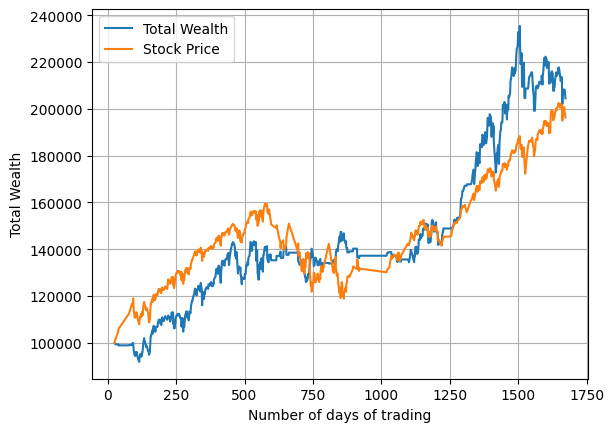

In [113]:
# record wealth
day1_dt = datetime.strptime(day1, '%Y-%m-%d')
days = positions.loc[positions.index >= day1_dt].index

wealth_records = []
price0 = []
days_since = (days - day1_dt).days
for date in days:
    position = positions.loc[date]
    price = stockprice.loc[date]['price']
    cash = position['cash']
    quantity = position['quantity']
    wealth = cash + quantity * price
    wealth_records.append(wealth)
    price0.append(stockprice.loc[date]['price'])

days_since = np.array(days_since)
W = np.array(wealth_records)
price0 = np.array(price0) * wealth_records[0] / price0[0]
import matplotlib.pyplot as plt
fig = plt.plot(days_since, W, label='Total Wealth')
plt.plot(days_since, price0,label='Stock Price')
plt.grid()
plt.xlabel("Number of days of trading")
plt.ylabel('Total Wealth')
plt.legend()


Evaluate the performance of the strategy:

In [114]:
# Measure the performance
# make series dataframe
wealth_df = pd.DataFrame(wealth_records, index=days, columns=['wealth'])
# 1. Annualized return
wealth_df['daily_return'] = wealth_df['wealth'].pct_change()
total_return = wealth_df['wealth'].iloc[-1] / wealth_df['wealth'].iloc[0] - 1
years = (wealth_df.index[-1] - wealth_df.index[0]).days / 365.25
annualized_return = (1 + total_return) ** (1/years) - 1
# 2. Annualized volatility
daily_return = wealth_df['daily_return'].dropna()
annualized_volatility = daily_return.std() * np.sqrt(252)
# 3. Sharpe ratio
risk_free_rate = 0.02 # assume 2% risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
# 4. Maximum drawdown
rolling_max = wealth_df['wealth'].rolling(window=252, min_periods=1).max()
drawdown = (wealth_df['wealth'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# print the performance metrics
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Annualized Return: 17.18%
Annualized Volatility: 22.30%
Sharpe Ratio: 0.68
Maximum Drawdown: -15.41%
